# Персонализация предложений интернет-магазина средствами МО

Руководство интернет-магазина "В один клик" поставило перед нашим отделом задачу - разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность. 

Руководитель отдела цифровых технологий уже сформулировал решение:
- Промаркировать уровень финансовой активности постоянных покупателей: «снизилась», если клиент стал покупать меньше товаров, или «прежний уровень».
- Собрать данные по клиентам по следующим группам:
 - Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
 - Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
 - Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
 - Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.
 
В конечном итоге нам нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца, и, используя данные модели и данные о прибыльности клиентов, выделить сегменты покупателей и разработать для них персонализированные предложения.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Исследовательский-анализ" data-toc-modified-id="Исследовательский-анализ-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследовательский анализ</a></span><ul class="toc-item"><li><span><a href="#Распределение-количественных-признаков" data-toc-modified-id="Распределение-количественных-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Распределение количественных признаков</a></span></li><li><span><a href="#Выборка-клиентов-по-покупательской-активности" data-toc-modified-id="Выборка-клиентов-по-покупательской-активности-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Выборка клиентов по покупательской активности</a></span></li></ul></li><li><span><a href="#Объединение-таблиц" data-toc-modified-id="Объединение-таблиц-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Объединение таблиц</a></span></li><li><span><a href="#Корреляционный-анализ" data-toc-modified-id="Корреляционный-анализ-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Корреляционный анализ</a></span></li><li><span><a href="#Использование-пайплайнов" data-toc-modified-id="Использование-пайплайнов-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Использование пайплайнов</a></span></li><li><span><a href="#Анализ-важности-признаков" data-toc-modified-id="Анализ-важности-признаков-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Анализ важности признаков</a></span></li><li><span><a href="#Сегментация-покупателей" data-toc-modified-id="Сегментация-покупателей-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Сегментация покупателей</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

**Описание данных**

1. `market_file.csv` - данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
 - id — номер покупателя в корпоративной базе данных.
 - Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
 - Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
 - Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это  даёт покупатель.
 - Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
 - Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
 - Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
 - Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
 - Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
 - Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
 - Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
 - Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
 - Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.


2. `market_money.csv` - данные о выручке, которую получает магазин с покупателя, сколько покупатель всего потратил за период взаимодействия с сайтом.
 - id — номер покупателя в корпоративной базе данных.
 - Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
 - Выручка — сумма выручки за период.


3. `market_time.csv` - данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.
 - id — номер покупателя в корпоративной базе данных.
 - Период — название периода, во время которого зафиксировано общее время.
 - минут — значение времени, проведённого на сайте, в минутах.


4. `money.csv` - данные о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
 - id — номер покупателя в корпоративной базе данных.
 - Прибыль — значение прибыли.

**Для дальнейшей работы нам необходимо установить библиотеки phik и shap**

In [1]:
#!pip install phik
#!pip install shap

In [2]:
import pandas as pd # Импорт необходимых библиотек
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np

from sklearn.pipeline import Pipeline # Инструменты для работы с пайплайнами
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler # Кодировщики, скейлеры
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer

from sklearn.metrics import f1_score # Метрики, методы анализа важности признаков

from sklearn.svm import SVC # Модели-классификаторы
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

try:
    import shap
except:
    print('shap не установлен')

try: # Библиотеки phik нету в окружении практикума по умолчанию. На всякий пожарный использую конструкцию try-except при импорте
    import phik
except:
    phik_loc = False
    print('phik не установлен')
else:
    phik_loc = True

In [3]:
import warnings # Отключаем предупреждения о будущих версиях библиотек(версии для проекта обновляться не будут)
warnings.filterwarnings("ignore", category=FutureWarning)

sns.set_style('dark') # Устанавливаем стиль для графиков
RANDOM_STATE = 38 # Константа определения случайных значений

## Загрузка данных

In [4]:
def dataset_info(ds, info=True): # Универсальная функция презентации данных
    print('Количество дубликатов:', ds.duplicated().sum())
    print('Длина датасета:', len(ds))
    display(ds.head())
    if info: 
        ds.info()
        display(ds.describe())

Для начала загрузим данные и ознакомимся с ними.

In [5]:
try: # Проект запускается либо в окружении практикума, либо локально. 
    ds_main = pd.read_csv('/datasets/market_file.csv')
except:
    ds_main = pd.read_csv('datasets/market_file.csv')
dataset_info(ds_main)

Количество дубликатов: 0
Длина датасета: 1300


,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


Ни одного явного дубликата. Названия столбцов вполне информативны, разве-что привести их к нижнему регистру. Тип сервиса "стандартт" вызывает подозрения, возможно это ошибка заполнения или дубликат значения. Отложим это на этап предобработки. Всем данным уже присвоен соответствующий тип. В целом можно сказать, что данные в хорошем состоянии.

In [6]:
try: 
    ds_money = pd.read_csv('/datasets/market_money.csv')
except:
    ds_money = pd.read_csv('datasets/market_money.csv')
dataset_info(ds_money)

Количество дубликатов: 0
Длина датасета: 3900


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


Никаких дубликатов, значения соответствуют ожидаемым. В датасете значительно больше записей, 3900 против 1300 из основного датасета. Это связано с тем, что здесь представлены несколько периодов для каждого айди.

In [7]:
try: 
    ds_time = pd.read_csv('/datasets/market_time.csv')
except:
    ds_time = pd.read_csv('datasets/market_time.csv')
dataset_info(ds_time)

Количество дубликатов: 0
Длина датасета: 2600


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


Похожая ситуация, записей больше из-за нескольких периодов. Видна грамматическая ошибка в значении "предыдцщий_месяц". Запомнили.

In [8]:
try: 
    ds_mean_money = pd.read_csv('/datasets/money.csv', sep=';', decimal=",")
except:
    ds_mean_money = pd.read_csv('datasets/money.csv', sep=';', decimal=",")
dataset_info(ds_mean_money)

Количество дубликатов: 0
Длина датасета: 1300


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


Среднее значение среднемесячной прибыли за последние 3 месяца - 4. Кажется, это не рубли, а как минимум тысячи рублей. Этот момент стоит уточнить у тех, кто составлял данные. Пока будем отталкиваться от предположения, что прибыль указывается в тысячах рублей. В остальном с данными всё в порядке, количество записей совпадает с основным датасетом. На этом можно заканчивать загрузку данных и переходить к следующему этапу.

## Предобработка данных

Для начала - приведём все названия столбцов к нижнему регистру для удобства.

In [9]:
ds_main.columns = ds_main.columns.str.lower()
ds_money.columns = ds_money.columns.str.lower()
ds_time.columns = ds_time.columns.str.lower()
ds_mean_money.columns = ds_mean_money.columns.str.lower()
print(ds_main.columns, ds_money.columns, ds_time.columns, ds_mean_money.columns)

Index(['id', 'покупательская активность', 'тип сервиса', 'разрешить сообщать',
       'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'популярная_категория',
       'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит'],
      dtype='object') Index(['id', 'период', 'выручка'], dtype='object') Index(['id', 'период', 'минут'], dtype='object') Index(['id', 'прибыль'], dtype='object')


Теперь пройдёмся по подозрительным значениям, которые нам удалось заметить. Например, тип сервиса "стандартт". На всякий случай посмотрим на уникальные значения всех категориальных столбцов.

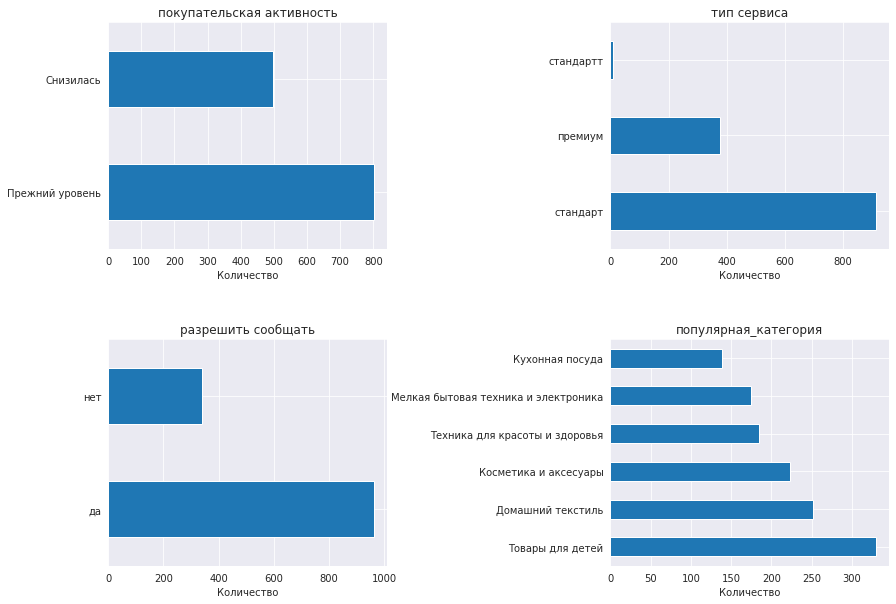

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2)
j=0
for i in ds_main.select_dtypes(exclude='number').columns:
    ds_main[i].value_counts().plot(kind='barh', figsize=(14, 10), ax=axes[j//2, j%2], grid=True)
    axes[j//2, j%2].set_title(i)
    axes[j//2, j%2].set_xlabel('Количество')
    j+=1
plt.subplots_adjust(wspace=0.8, hspace=0.4)
plt.show()

Да, значение "стандартт" - неявный дубликат значения "стандарт". В остальных столбцах неявных дубликатов нет. Заодно можно заметить явный дисбаланс классов целевого признака - гораздо больше клиентов, чья покупательская способность осталась на прежнем уровне.

In [11]:
ds_main.loc[ds_main['тип сервиса'] == 'стандартт', 'тип сервиса'] = 'стандарт'
ds_main['тип сервиса'].unique()

array(['премиум', 'стандарт'], dtype=object)

Раз-уж заговорили про категориальные параметры - посмотрим на столбцы с периодами из `ds_time` и `ds_money`.

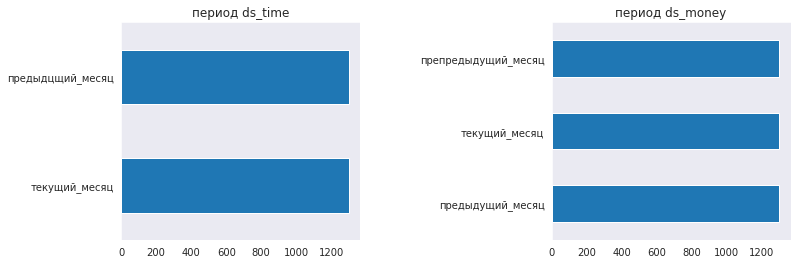

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2)
ds_time['период'].value_counts().plot(kind='barh', figsize=(12, 4), title='период ds_time', ax=axes[0])
ds_money['период'].value_counts().plot(kind='barh', figsize=(12, 4), title='период ds_money', ax=axes[1]);
plt.subplots_adjust(wspace=0.8)

А это уже простая ошибка наименования. Исправим её

In [13]:
ds_time.loc[ds_time['период'] == 'предыдцщий_месяц', 'период'] = 'предыдущий_месяц'
ds_time['период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

И на этом предобработку можно заканчивать. Мы привели названия столбцов к нижнему регистру, избавились от двух неявных дубликатов в данных, а также выявили дисбаланс классов.

## Исследовательский анализ

### Распределение количественных признаков

Для начала проанализируем основной датасет. Распределение категориальных признаков мы уже смотрели при выявлении неявных дубликатов, теперь посмотрим на распределение количественных признаков.

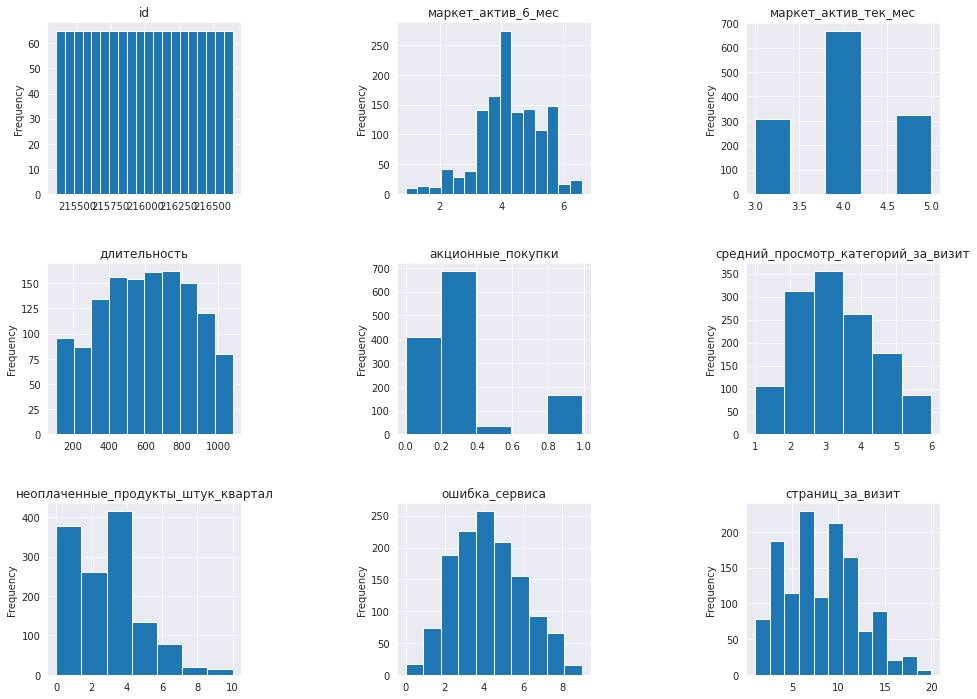

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=3)
j=0
bins=[20, 15, 5, 10, 5, 6, 7, 10, 12]
for i in ds_main.select_dtypes(include='number').columns:
    ds_main[i].plot(kind='hist', bins=bins[j], ax=axes[j//3, j%3], figsize=(16, 12), grid=True)
    axes[j//3, j%3].set_title(i)
    j+=1

plt.subplots_adjust(wspace=0.8, hspace=0.4)
plt.show()

`id` распределены равномерно и последовательно, записи в выборку явно выбирались не случайным образом, это может быть как хорошо по причине сравнительно одинаковой свежести данных, так и плохо по причине возможного наличия в выборке закономерностей, которых нету в генеральной совокупности.

Отдел маркетинга не зря получает зарплату - в среднем от 3 до 6 маркетинговых коммуникаций с абсолютным большинством клиентов каждый месяц из числа последних шести, и текущий месяц показывает схожую картину. Отсутствие нулевых значений в текущем месяце выглядит подозрительно, но не невозможно.

Признак `акционные_покупки` показывает, что клиенты разбились на 2 условных лагеря - основной, совершающий от 0 до 40% акционных покупок, и чуть менее крупный, которые совершают исключительно покупки товаров по акции - от 80 до 100%.

`неоплаченные_продукты` перекошены влево, большинство старается оплачивать как можно больше своих покупок.

Все остальные распределения похожи на нормальное.

Теперь взглянем на данные из остальных таблиц.

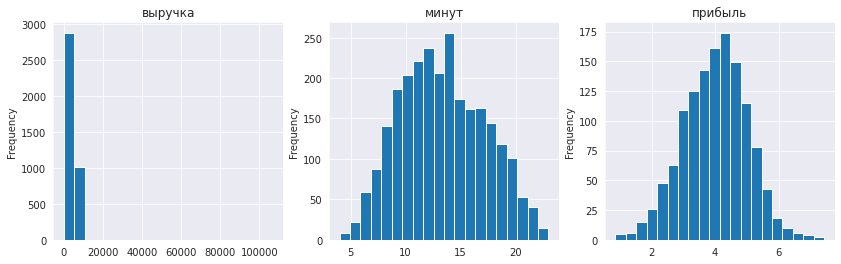

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=3)
j=0
for i in [ds_money['выручка'], ds_time['минут'], ds_mean_money['прибыль']]:
    i.plot(kind='hist', bins=20, figsize=(14, 4), ax=axes[j], title=i.name, grid=True)
    j+=1

А вот и первая аномалия. Выручка за один из месяцев свыше 100.000

In [16]:
ds_money[ds_money['выручка']>80000]

,id,период,выручка
98,215380,текущий_месяц,106862.2


Не исключено, что такой клиент действительно существует, но при обучении модели он будет нам мешать.

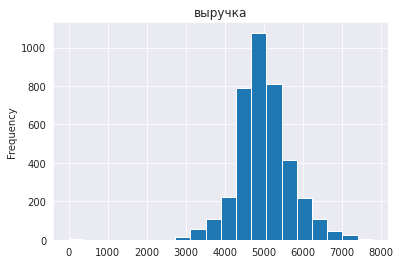

In [17]:
ds_money = ds_money[ds_money['выручка']<100000]
ds_money['выручка'].plot(kind='hist', bins=20, title='выручка', grid=True);

Теперь все распределения выглядят нормально.

Посмотрим также на ящиковые диаграммы.

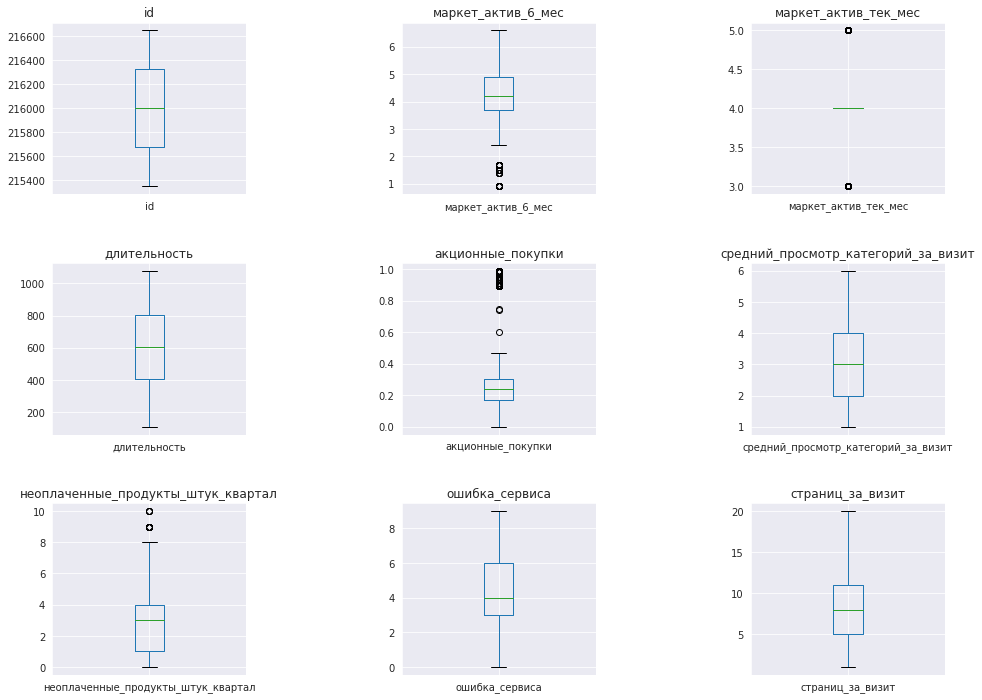

In [18]:
fig, axes = plt.subplots(nrows=3, ncols=3)
j=0
for i in ds_main.select_dtypes(include='number').columns:
    ds_main[i].plot(kind='box', ax=axes[j//3, j%3], figsize=(16, 12), grid=True)
    axes[j//3, j%3].set_title(i)
    j+=1

plt.subplots_adjust(wspace=0.8, hspace=0.4)
plt.show()

Есть несколько записей с крайне низкой маркетинговой активностью за 6 месяцев. За текущий месяц есть только значения 3, 4 или 5, что уже больше смахивает на категории. В акционных покупках группа аномально высоких значений - это клиенты, которые покупают в основном товары по акции. И пара аномалий в неоплаченных продуктах. Ничего такого о чём стоило-бы беспокоиться.

### Выборка клиентов по покупательской активности

Теперь найдём клиентов, которые в течение последних трёх месяцев совершали хотя-бы одну покупку каждый месяц. 

In [19]:
ds_money_new = ds_money.set_index('id') # Устанавливаем айди как индекс
for i in ds_money_new['период'].unique(): # Для каждого уникального периода создаётся новый столбец
    ds_money_new[i] = ds_money_new.loc[ds_money_new['период'] == i, 'выручка']
ds_money_new['id'] = ds_money_new.index # Защита от сброса похожих записей. Временно возвращаю айди перед сбросом дубликатов
ds_money_new = ds_money_new.drop(['период', 'выручка'], axis=1).drop_duplicates().replace(0, np.nan).dropna()
ds_money_new = ds_money_new.drop(['id'], axis=1)
ds_money_new.columns = ds_money_new.columns+'_выручка'
dataset_info(ds_money_new, False) # Убираем ненужные столбцы, сбрасываем дубликаты, заменяем нули на nan и сбрасываем пропуски.

Количество дубликатов: 21
Длина датасета: 1296


,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_выручка
id,,,
215349,4472.0,4971.6,5216.0
215350,4826.0,5058.4,5457.5
215351,4793.0,6610.4,6158.0
215352,4594.0,5872.5,5807.5
215353,5124.0,5388.5,4738.5


А вот и действующие клиенты, а заодно и выручка в каждом месяце от них. Дальше на очереди объединение таблиц.

## Объединение таблиц

Данные о выручке уже готовы. Проведём такую-же подготовку для данных с временем посещения сайта

In [20]:
ds_time_new = ds_time.set_index('id') # Всё то-же самое, что и в ячейке выше, но для другой таблицы
for i in ds_time_new['период'].unique():
    ds_time_new[i] = ds_time_new.loc[ds_time_new['период'] == i, 'минут']
ds_time_new['id'] = ds_time_new.index
ds_time_new = ds_time_new.drop(['период', 'минут'], axis=1).drop_duplicates()
ds_time_new = ds_time_new.drop(['id'], axis=1)
ds_time_new = ds_time_new[ds_time_new.index.isin(ds_money_new.index)] # Оставляю только записи, чей айди уже присутствует в ds_money_new
ds_time_new.columns = ds_time_new.columns+'_минут'
dataset_info(ds_time_new, False)

Количество дубликатов: 1018
Длина датасета: 1296


,текущий_месяц_минут,предыдущий_месяц_минут
id,,
215349,10,12
215350,13,8
215351,13,11
215352,11,8
215353,10,10


А теперь - объединим таблицы в одну.

In [21]:
ds_new = ds_main[ds_main['id'].isin(ds_money_new.index)].set_index('id')
ds_new = ds_new.join(ds_money_new).join(ds_time_new)
dataset_info(ds_new, False)

Количество дубликатов: 11
Длина датасета: 1296


,покупательская активность,тип сервиса,разрешить сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_выручка,текущий_месяц_минут,предыдущий_месяц_минут
id,,,,,,,,,,,,,,,,,
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4472.0,4971.6,5216.0,10,12
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,4826.0,5058.4,5457.5,13,8
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6610.4,6158.0,13,11
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5872.5,5807.5,11,8
215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5124.0,5388.5,4738.5,10,10


Это было быстро(сравнительно). В следующем этапе посмотрим на корреляцию признаков.

## Корреляционный анализ

Для начала посмотрим на матрицу корреляции Пирсона.

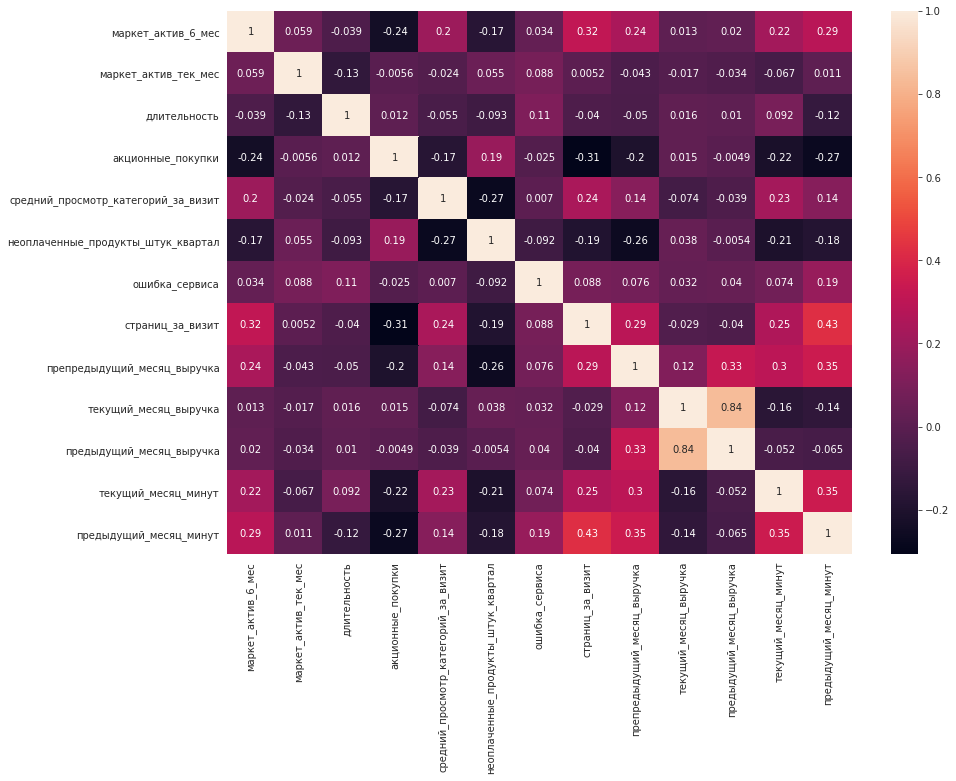

In [22]:
plt.figure(figsize=(14, 10))
sns.heatmap(ds_new.corr(), annot=True);

Выручка за текущий и предыдущий месяц сильно коррелируют. На границе мультиколлинеарности.

interval columns not set, guessing: ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'препредыдущий_месяц_выручка', 'текущий_месяц_выручка', 'предыдущий_месяц_выручка', 'текущий_месяц_минут', 'предыдущий_месяц_минут']


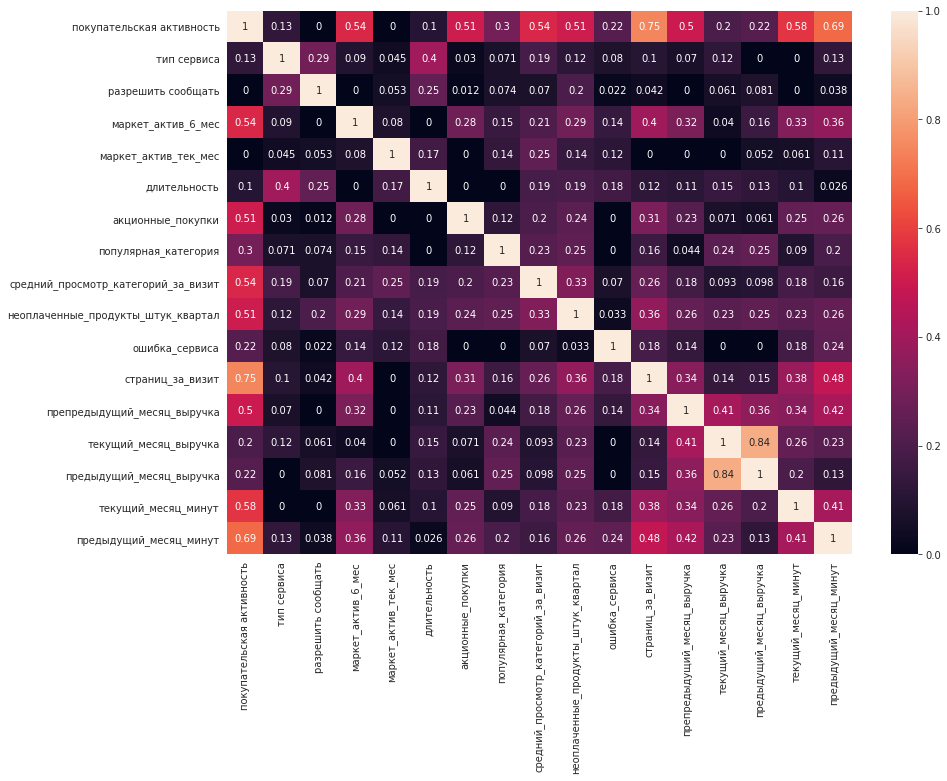

In [23]:
if phik_loc:
    plt.figure(figsize=(14, 10))
    sns.heatmap(ds_new.phik_matrix(), annot=True);
else:
    print('Тут должна была быть матрица корреляции phik, но библиотеку забыли установить')

Количество страниц за визит и минут, проведённых на сайте, сильно влияют на покупательскую активность. 

И видна точно такая-же взаимосвязь выручки за текущий и предыдущий месяц. Мультиколлинеарность будет нам мешать, исключим её, удалив один из признаков. 

In [24]:
ds_new = ds_new.drop('текущий_месяц_выручка', axis=1)

Теперь перейдём к анализу распределений. Начнём с категориальных признаков.

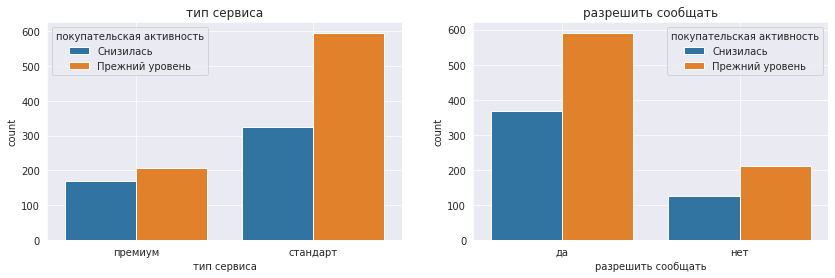

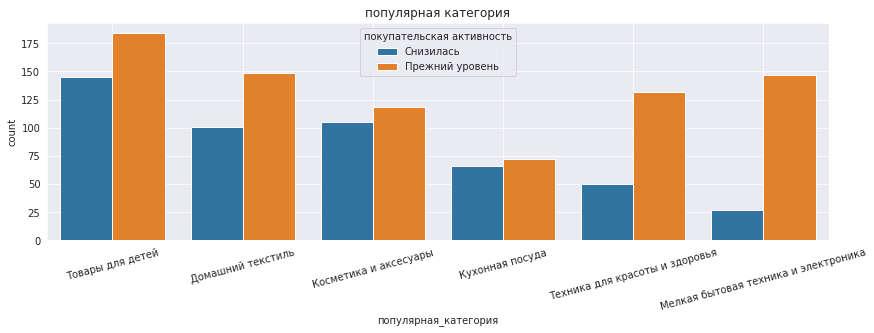

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
j=0

for i in ['тип сервиса', 'разрешить сообщать']:
    sns.countplot(data=ds_new, x=i, hue='покупательская активность', ax=axes[j])
    axes[j].set_title(i)
    axes[j].grid()
    j+=1
plt.show()

plt.figure(figsize=(14, 4))
plt.xticks(rotation=15)
plt.title('популярная категория')
sns.countplot(data=ds_new, x='популярная_категория', hue='покупательская активность');
plt.grid()

Небольшой перекос у типа сервиса, у клиентов с сервисом типа премиум в процентном соотношении чаще снижается покупательская активность. 

Согласие на рассылку мало влияет на целевой признак. 

А вот в популярной категории разница разительная. В группе риска у нас клиенты, предпочитающие покупать кухонную посуду или косметику. А у фанатов бытовой техники или техники для красоты наоборот реже снижается покупательская активность.

На категориальные признаки посмотрели, теперь взглянем на зависимость целевого признака от числовых.

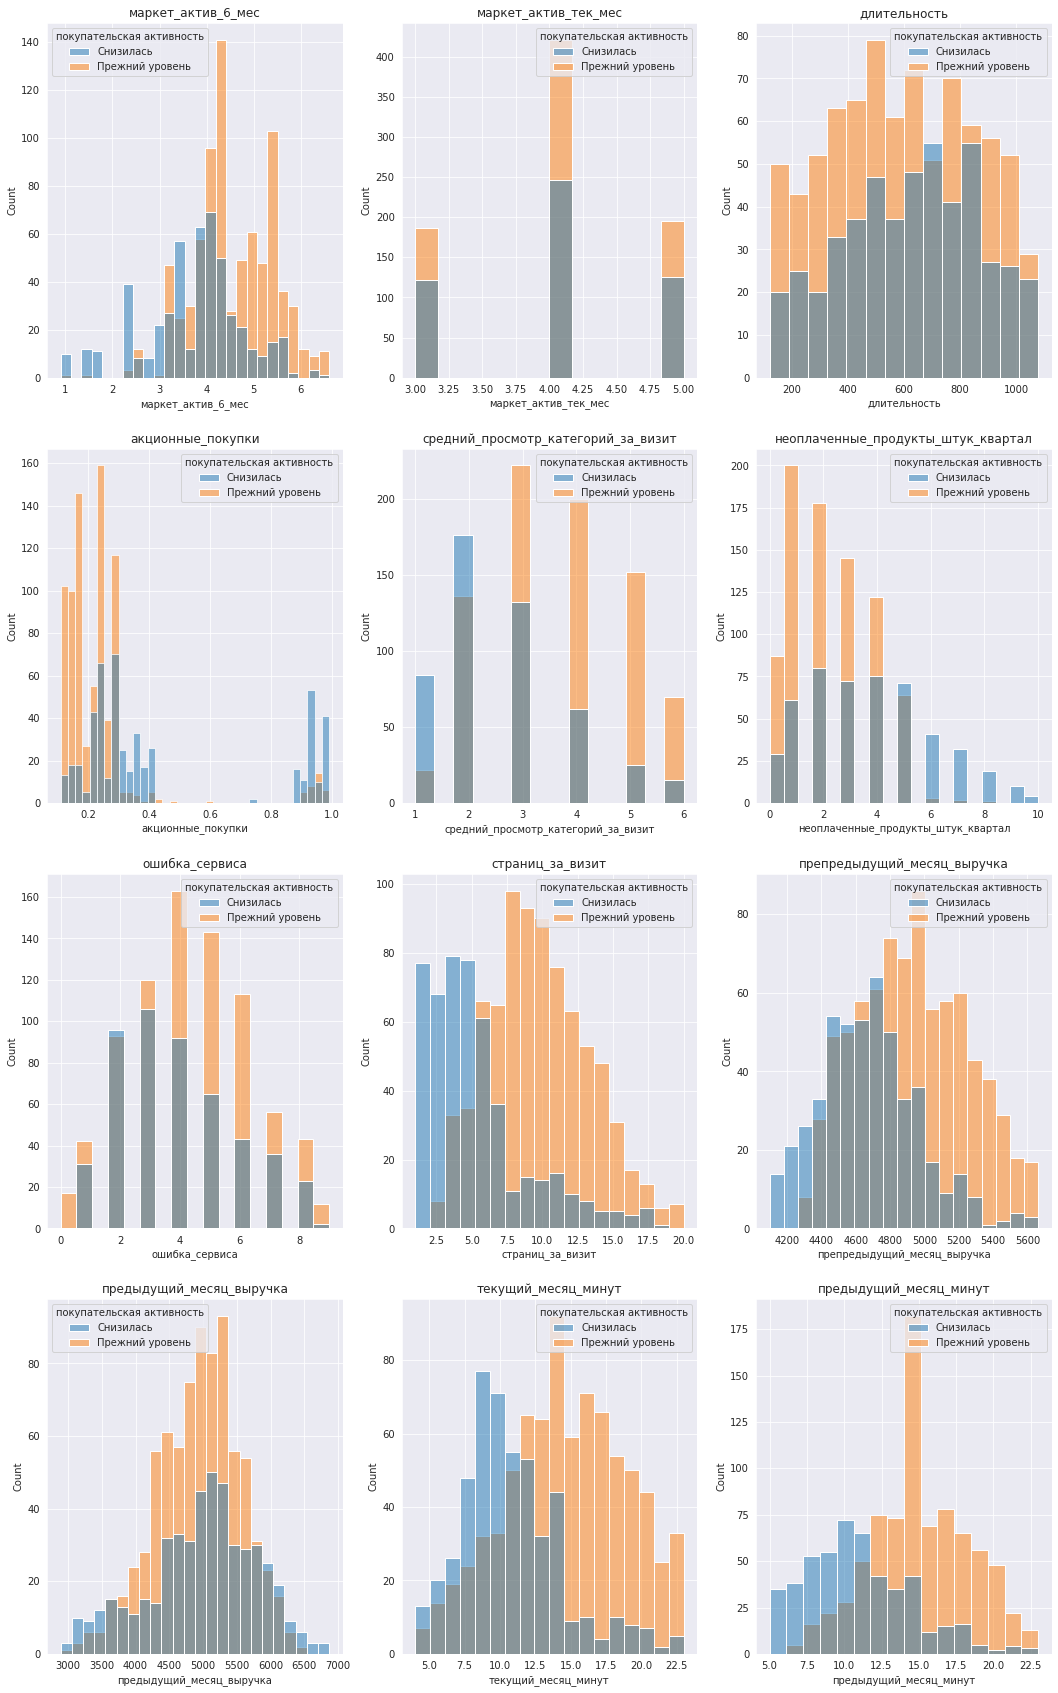

In [26]:
fig, axes = plt.subplots(ncols=3, nrows=4, figsize=(18, 30))
j=0
# Гистограмма строится для каждого столбца с числовыми данными, выделяя категории покупательской активности
for i in ds_new.select_dtypes(include = 'number').columns:
    sns.histplot(data=ds_new, x=i, hue='покупательская активность', ax=axes[j//3, j%3])
    axes[j//3, j%3].set_title(i)
    axes[j//3, j%3].grid()
    j+=1
plt.show()

Видны явные закономерности между целевым признаком и:
- Акционными покупками;
- Средним просмотром категорий за визит;
- Неоплаченными продуктами;
- Страницами за визит;
- Выручкой в позапрошлом месяце;
- Минутами, проведёнными на сайте за текущий и предыдущий месяц.

## Использование пайплайнов

Целевой признак `покупательская активность` - бинарный. Для удобства заменим `Снизилась` на 1, а `Прежний уровень` на 0.

In [27]:
ds_new.loc[ds_new['покупательская активность'] == 'Снизилась', 'покупательская активность'] = 1
ds_new.loc[ds_new['покупательская активность'] == 'Прежний уровень', 'покупательская активность'] = 0
ds_new['покупательская активность'] = pd.to_numeric(ds_new['покупательская активность'])

Теперь разделим данные на выборки. Покупательская активность - целевой признак, его и будем прогнозировать.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    ds_new.drop('покупательская активность', axis=1), 
    ds_new['покупательская активность'], 
    random_state=RANDOM_STATE, 
    stratify=ds_new['покупательская активность']
)

Дальше создадим пайплайны для подготовки данных

In [29]:
encode_pipe = Pipeline([
    ('encode', OneHotEncoder(drop='first', sparse=False)),
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

In [30]:
encode_columns = X_train.select_dtypes(exclude='number').columns
num_columns = X_train.select_dtypes(include='number').columns
data_preprocessor = ColumnTransformer(
    [
        ('encode', encode_pipe, encode_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

И объединим подготовку с самим обучением.

In [31]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

Теперь создадим матрицу гиперпараметров. Возьмём за основу 4 модели - дерево решений, к-ближайших соседей, метод опорных векторов и логистическую регрессию. Для каждой модели переберём виды скейлинга и кодирования входных признаков, а также уникальные для каждой модели гиперпараметры.

In [32]:
param_grid = [
    {
        'models':[DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth':range(2, 10),
        'models__min_samples_split':range(2, 10),
        'models__min_samples_leaf':range(1, 10),
        'preprocessor__num':[StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__encode':[OneHotEncoder(drop='first', sparse=False), OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)]
    },
    {
        'models':[KNeighborsClassifier()],
        'models__n_neighbors':range(1, 10),
        'preprocessor__num':[StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__encode':[OneHotEncoder(drop='first', sparse=False), OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)]
    },
    {
        'models':[SVC(random_state=RANDOM_STATE)],
        'models__kernel':['linear', 'poly', 'rbf', 'sigmoid'],
        'models__degree':range(1, 6),
        'preprocessor__num':[StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__encode':[OneHotEncoder(drop='first', sparse=False), OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)]
    },
    {
        'models':[LogisticRegression(random_state=RANDOM_STATE)],
        'models__penalty':['l1', 'l2'],
        'preprocessor__num':[StandardScaler(), MinMaxScaler(), 'passthrough'],
        'preprocessor__encode':[OneHotEncoder(drop='first', sparse=False), OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)]
    }
]

И, наконец, запустим кросс-валидацию. Гиперпараметров получилось много, поэтому используем `RandomizedSearchCV()`, чтобы не умереть от старости, пока всё будет считаться. За метрику возьмём f1_score, нам одинаково важно исключить как ложноположительные, так и ложноотрицательные ошибки.

In [33]:
grid = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_grid,
    cv=15,
    scoring='f1',
    n_jobs=-1,
    random_state=RANDOM_STATE
)
grid.fit(X_train, y_train)
print('Лучшая оценка:', grid.best_score_.round(2), 'на модели с параметрами:')
grid.best_params_

Лучшая оценка: 0.82 на модели с параметрами:


{'preprocessor__num': MinMaxScaler(),
 'preprocessor__encode': OneHotEncoder(drop='first', sparse=False),
 'models__min_samples_split': 2,
 'models__min_samples_leaf': 5,
 'models__max_depth': 8,
 'models': DecisionTreeClassifier(max_depth=8, min_samples_leaf=5, random_state=38)}

Лучше всех себя показала модель дерева решений.

## Анализ важности признаков

Самое время заглянуть под капот нашей модели и выяснить, какие признаки она считает наиболее важными. Для этого мы обратимся к библиотеке shap. Для начала необходимо обучить модель на самых лучших параметрах, какие нам удалось найти.

In [34]:
scaler = MinMaxScaler()
encoder = OneHotEncoder(drop='first', sparse=False)

X_train_se = pd.DataFrame(encoder.fit_transform(X_train[encode_columns]), columns=encoder.get_feature_names()).join(
    pd.DataFrame(scaler.fit_transform(X_train[num_columns]), columns=num_columns))
X_test_se = pd.DataFrame(encoder.transform(X_test[encode_columns]), columns=encoder.get_feature_names()).join(
    pd.DataFrame(scaler.transform(X_test[num_columns]), columns=num_columns))

model = DecisionTreeClassifier(max_depth=8, min_samples_leaf=5, random_state=RANDOM_STATE)
model.fit(X_train_se, y_train)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=5, random_state=38)

Теперь загрузим модель в специально обученный explainer, и попросим сгенерировать SHAP-значения. И сразу-же выведем наглядный график. Низкие SHAP-значения склоняют модель к присвоению объекту класса 0, высокие, соответственно, к классу 1. Каждая точка - одно значение параметра, цвет отображает высоту значения.

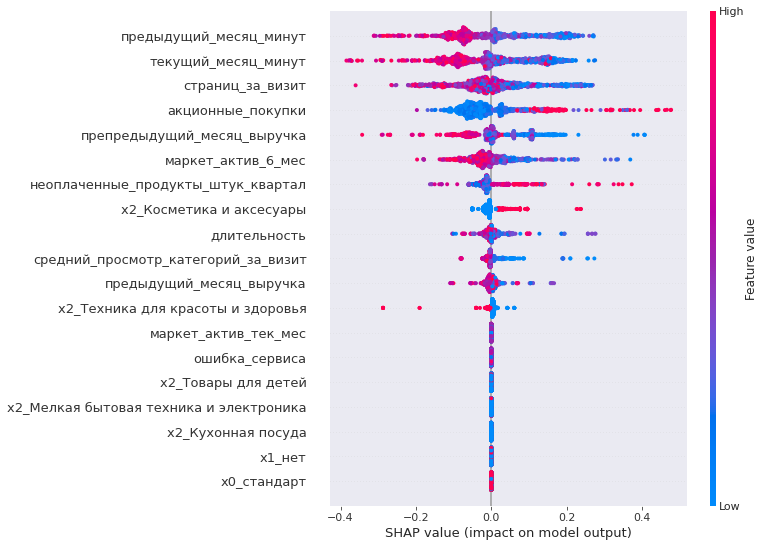

In [35]:
explainer = shap.TreeExplainer(model, X_train_se)
shap_values = explainer(X_train_se)
shap.plots.beeswarm(shap_values[:, :, 1], max_display=20)

Высокие значения времени посещения сайта, посещенных страниц за визит, выручки за позапрошлый месяц, рекламной активности и т.д склоняют модель спрогнозировать, что покупательская активность клиента останется на прежнем уровне.

Высокие значения процента акционных покупок, количества неоплаченных товаров и предпочтение в покупке косметики склоняют модель спрогнозировать, что покупательская активность клиента упадёт.

На решения модели практически никак не влияют - Ошибки сервиса, рекламная активность в текущем месяце, предпочтения в товарах для детей, мелкой бытовой технике или кухонной посуде, согласие на рассылку и тип сервиса. В будущем для повышения точности прогнозирования модели от этих признаков можно будет попробовать отказаться.

Теперь посмотрим на конкретные примеры. Возьмём 2 записи о клиентах, один из которых, по прогнозам модели, станет покупать меньше, а второй нет. Построим для каждого отдельный график.

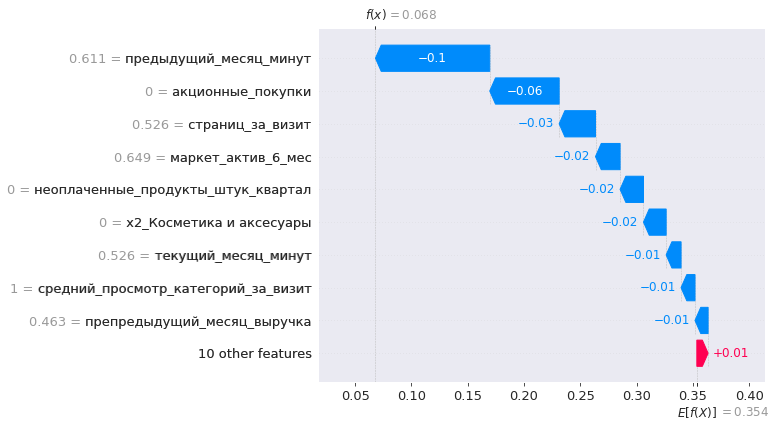

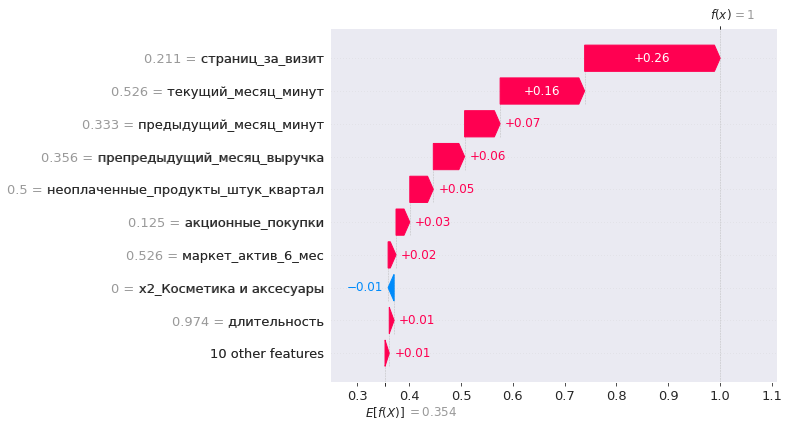

In [36]:
shap.plots.waterfall(shap_values[75, :, 1])
shap.plots.waterfall(shap_values[18, :, 1])

Одни из параметров, ожидаемо, влияют на решения модели сильнее других. При этом для разных примеров важность отдельного параметра меняется. Так, например, нулевое значение акционных покупок стоит на втором месте по важности признаков в первом примере, а во втором находится на шестом месте, со значением 0.125.

Итого, можно считать признаки, отражающие активность клиента на сайте, основополагающими для принятия решений при прогнозировании. Количество проведённых минут и количество посещённых страниц имеют наибольший вес. В целом можно сказать, что чем больше клиент проводит времени на сайте, тем меньше вероятность снижения покупательской активности.

## Сегментация покупателей

Теперь мы выделим сегмент покупателей, отдающих предпочтение акционным товарам, и чья покупательская активность снизилась в последнее время.

In [37]:
segment = ds_new.join(ds_mean_money.set_index('id'))
segment['прибыль'] = segment['прибыль']*1000
segment = segment[(segment['покупательская активность'] == 1)&(segment['акционные_покупки']>0.8)]
dataset_info(segment, False)

Количество дубликатов: 0
Длина датасета: 131


,покупательская активность,тип сервиса,разрешить сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,препредыдущий_месяц_выручка,предыдущий_месяц_выручка,текущий_месяц_минут,предыдущий_месяц_минут,прибыль
id,,,,,,,,,,,,,,,,,
215351,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,4793.0,6158.0,13,11,4870.0
215352,1,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,4594.0,5807.5,11,8,4210.0
215364,1,премиум,да,4.3,4,708,0.98,Домашний текстиль,3,3,3,3,4942.0,5795.5,9,11,2670.0
215365,1,стандарт,да,3.9,4,167,0.95,Техника для красоты и здоровья,6,4,2,5,4190.0,4577.0,10,6,3650.0
215373,1,премиум,нет,3.8,3,811,0.90,Товары для детей,2,5,5,3,4293.0,4632.0,8,10,3690.0


Теперь посмотрим на распределение категориальных признаков в сегменте. Тип сервиса и согласие на рассылку имеют почти нулевой вес при прогнозе, а следовательно никак не влияют на покупательскую активность, и нам они не интересны. Остаётся популярная категория.

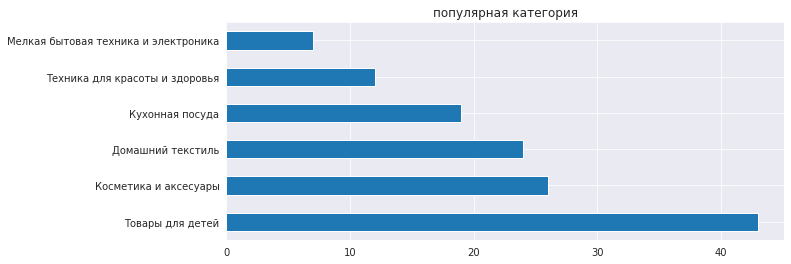

In [38]:
segment['популярная_категория'].value_counts().plot(kind='barh', title='популярная категория', figsize=(10, 4), grid=True);

Самая популярная категория у сегмента - товары для детей. Кажется, картина начинает складываться. Дети вырастают, активность падает. Решением в данной ситуации могут стать персонализированные скидки на школьные/канцелярские товары.

Следом по популярности идёт самая рискованная категория - косметика. Она имеет наибольший вес в модели среди остальных категорий товаров, и склоняет прогноз в сторону снижения активности. Возможно, когда среди косметики не находится товаров со скидкой, покупатели уходят к конкурентам. Здесь решением может стать фокусировка на поддержании акций, чтобы в любой момент хотя-бы один товар из этой категории продавался со скидкой.

Дальше взглянем на количественные признаки. Возможно, найдём какую-то закономерность.

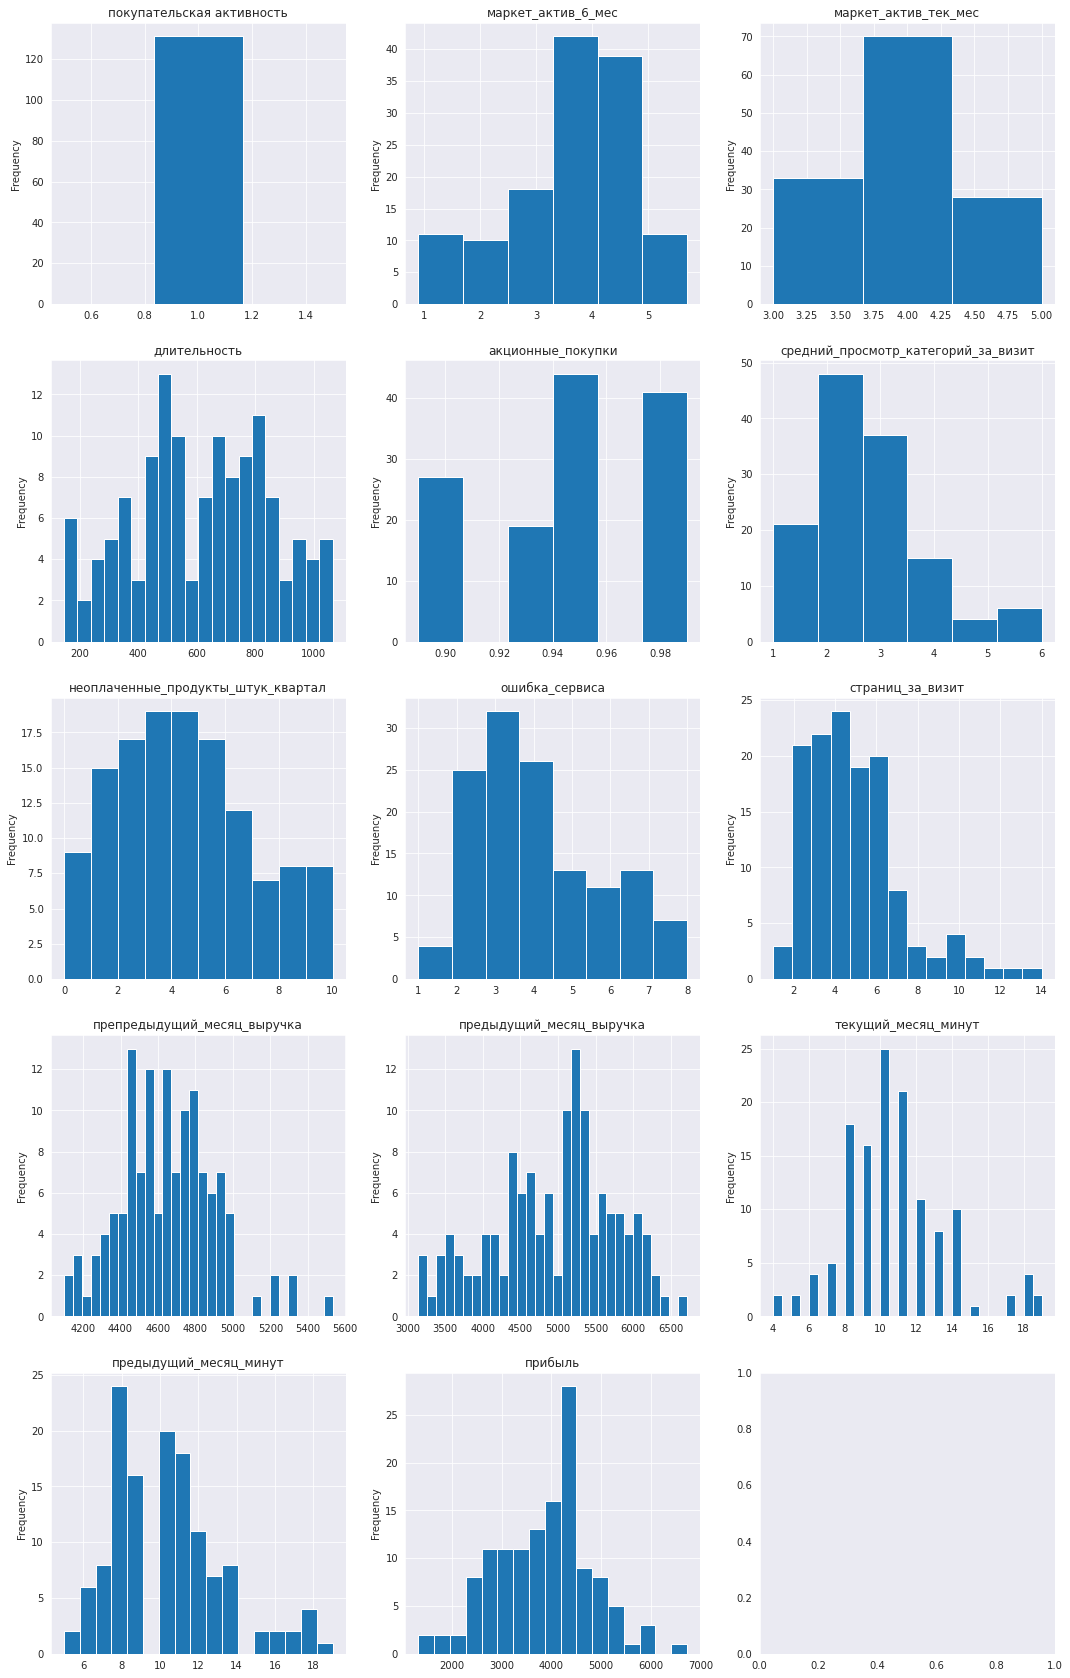

In [39]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 30))
j=0
bins=[3, 6, 3, 20, 6, 6, 10, 8, 14, 30, 30, 30, 17, 17, 30]

for i in segment.select_dtypes(include='number').columns:
    segment[i].plot(kind='hist', ax=axes[j//3, j%3], grid=True, bins=bins[j])
    axes[j//3, j%3].set_title(i)
    j+=1
plt.show()

Кажется, покупатели из сегмента не тратят много времени на просмотр различных категорий, что, как мы помним, является тревожным звонком. Учитывая их предпочтения в акционных покупках, здесь может помочь создание подборок с акционными товарами из различных категорий. Так клиенты просмотрят больше категорий в поисках интересующих их товаров.

Точно так-же, количество страниц за визит печально мал**о**. Подборки с акционными товарами могут помочь и здесь.

Остальные распределения выборки похожи на распределения генеральной совокупности.

**Промежуточный вывод**

Итого, мы выделили сегмент покупателей, которые отдают предпочтение акционным товарам, и чья покупательская активность снизилась, и сформировали следующие предложения:
- Выдавать клиентам, покупающим в основном товары для детей, и чья активность снизилась, персонализированные скидки на школьные/канцелярские товары.
- Поддерживать наличие акционных товаров в разделе косметики и аксессуаров.
- Создавать подборки акционных товаров из различных категорий.

## Общий вывод

**Задача**

Перед нами стояла задача разработать модель, которая предскажет снижение покупательской активности клиента в следующие 3 месяца.

**Исходные данные и предобработка**

Мы работали с данными о клиентах интернет-магазина, содержащимися в нескольких таблицах - `market_file.csv`, `market_money.csv`, `market_time.csv` и `money.csv`.

В рамках предобработки, мы:
- привели названия столбцов к нижнему регистру
- исключили из данных неявный дубликат типа сервиса "стандарт"
- исправили опечатку в названии периода таблицы со временем посещения сайта

**Поиск лучшей модели**

Для того чтобы подобрать модель, которая лучше всех справится с прогнозом покупательской активности, мы:
- Использовали при подготовке данных 2 вида кодировщика и 2 вида скейлера
- Перебрали 4 вида классификационных моделей прогнозирования
- Перебрали гиперпараметры каждой модели
- Определили метрику f1_score как наиболее подходящую для оценки качества модели.

И по итогу, получили самую перспективную модель - дерево принятия решений, с максимальной глубиной 8 и минимальным числом объектов в листьях - 5. С кодировщиком OneHotEncoder и скейлером MinMaxScaler.

**Сегментация покупателей**

Был выделен сегмент покупателей с максимальным процентом акционных покупок и сниженной покупательской активностью. И были сделаны следующие выводы:
- Клиенты из сегмента отдают предпочтение категории товаров для детей и категории косметики.
- Клиенты из сегмента посещают мало категорий товаров, и мало страниц сайта.

По выводам о сегменте были сделаны предложения о персонализации скидок для клиентов, покупающих в основном товары для детей или косметику, а также о создании подборок с акционными товарами из различных категорий.